In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

from pymc3 import traceplot

import glam

%load_ext autoreload
%autoreload 2

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Test Case 1: Vaidya & Fellows (2015)

Here, we simulate a between subjects design. The example follows the analyses made in Vaidya & Fellows (2015), where different groups of frontal lobe patients (group assignment by exact region lesioned by stroke) exhibit different gaze biases in a 3 alternative value based choice task.

We simulate three groups (the paper used 4, but we're simplifying a bit) with `high`, `medium` and `low` gaze bias, fit GLAM, and analyse differences in gaze-bias estimates.

As in the real world reference, the groups have different sizes. Every subject performed 100 trials.

## Simulate data

In [2]:
# Set the random seed, so that we can re-create exactly the same data, if we need to
np.random.seed(1313)

# Setup up the GLAM instance
model = glam.GLAM()

# There are three groups, labeled high, medium and low
groups = ['high', 'medium', 'low']

# The three groups are of different sizes
N = dict(high=27,
         medium=12,
         low=13)

# Every subject performed 100 trials of a 3-Alternative-Forced-Choice task
n_trials = 100
n_items = 3

# The groups differ in their mean gaze-bias parameter
gamma = dict(high=np.clip(np.random.normal(loc=-0.5, scale=0.4, size=N['high']), -1.0, 1.0),
             medium=np.clip(np.random.normal(loc=0.1, scale=0.4, size=N['medium']), -1.0, 1.0),
             low=np.clip(np.random.normal(loc=0.6, scale=0.3, size=N['low']), -1.0, 1.0))
# other parameters don't SYSTEMATICALLY vary between conditions, but vary between groups because there is variance between subjects

# We now simulate data for each group, using the specific group details, we set up
for group in groups:
    model.simulate_group(kind='individual',
                         n_individuals=N[group],
                         parameters=dict(gamma=gamma[group],
                                         v=np.clip(np.random.normal(loc=0.0002, scale=0.0001, size=N[group]), 0.00001, 0.01),
                                         s=np.clip(np.random.normal(loc=0.0075, scale=0.001, size=N[group]), 0.001, 0.05),
                                         tau=np.clip(np.random.normal(loc=1.0, scale=0.1, size=N[group]), 0.0, 5.0),
                                         t0=np.zeros(N[group])),
                         n_items=n_items,
                         n_trials=n_trials,
                         label=group)

# Rename 'condition' column to 'group'
model.data.rename(columns={'condition': 'group'}, inplace=True)

In [3]:
model.data.head()

,choice,repeat,rt,subject,trial,item_value_0,gaze_0,item_value_1,gaze_1,item_value_2,gaze_2,group
0,0.0,0.0,616.0,0.0,0.0,7,0.386609,0,0.574780,0,0.038610,high
1,0.0,0.0,406.0,0.0,1.0,7,0.520455,7,0.004362,0,0.475183,high
2,2.0,0.0,589.0,0.0,2.0,8,0.076069,3,0.463248,5,0.460683,high
3,2.0,0.0,367.0,0.0,3.0,0,0.313111,5,0.074330,9,0.612559,high
4,1.0,0.0,377.0,0.0,4.0,8,0.178409,5,0.503982,4,0.317608,high


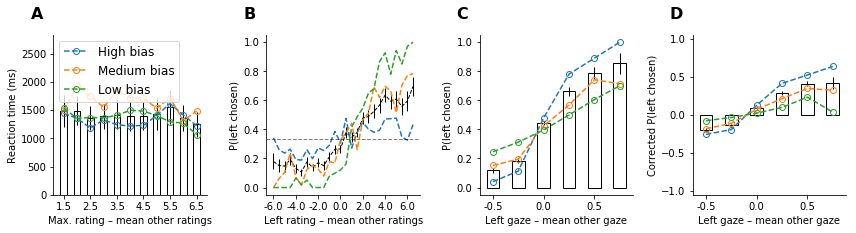

In [5]:
glam.plot_fit(model.data,
              [model.data[model.data['group'] == 'high'],
               model.data[model.data['group'] == 'medium'],
               model.data[model.data['group'] == 'low']],
              prediction_labels=['High bias', 'Medium bias', 'Low bias']);

The data looks somewhat plausible. Similar to what would be obtained experimentally (e.g., Krajbich & Rangel, 2011; Krajbich et al., 2010).

## Model fitting

### Model set up

We now need to specify the exact model to fit to the data. We need to indicate that the gaze-bias parameter shall depend on the `condition` variable of our data. Note that this variable can have any name, but the `simulation` method used above just happens to call it `condition`.

We also have to choose whether we want to fit the model hierarchically to all of our subjects, or to each individual subject alone. We choose the hierarchical model here.

In [7]:
model.make_model(kind='hierarchical',
                 depends_on=dict(gamma='group'),
                 t0_val=0)

Generating hierarchical model for 52 subjects...


### Parameter estimation

The model is specified. Now the parameters can be estimated. `GLAMbox` implements the model as a `pymc3` model object, that can be fit with all fitting procedures included in `pymc3`. For large hierarchical models in particular, we made the experience that automatic differentiation variational inference (ADVI; Kucukelbir,  Ranganath, Gelman & Blei, 2015) performs well and is very fast.

In [8]:
model.fit(method='ADVI', n_advi=50000)

Fitting 1 model(s) using ADVI...
  Fitting model 1 of 1...


Average Loss = 39,923: 100%|██████████| 50000/50000 [10:04<00:00, 82.76it/s]
Finished [100%]: Average Loss = 39,923


/!\ Automatically setting parameter precision...


## Analysis

Now that parameters are estimated, it would be reasonable to analyse resulting parameter estimates. After fitting, the `GLAM` model instance automatically extracts posterior modes for every estimated parameter. However, in order to make full use of the Bayesian parameter estimation procedure, the `pymc3` trace object is also attached to the model instance (note that in the case of variational inference, this trace is simply being sampled using the estimated variational parameters. It is not the result of an MCMC algorithm, as would be obtained if estimation would have been done using traditional sampling techniques like Metropolis or NUTS sampling).

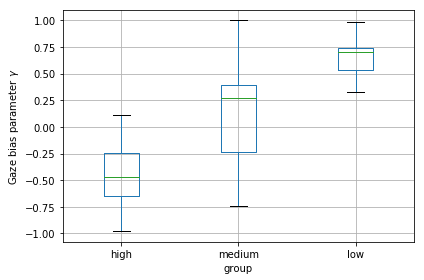

In [9]:
group_label = np.repeat(np.array(groups), np.array([N[group] for group in groups]))

gamma_estimates = np.hstack([model.estimates['gamma_{}'.format(group)]
                             for group in groups]).ravel()

df = pd.DataFrame(dict(group=group_label,
                       gamma=gamma_estimates))
df['group'] = pd.Categorical(group_label,
                             categories=['high', 'medium', 'low'],
                             ordered=True)

fig, ax = plt.subplots()
df.boxplot(column='gamma', by='group', ax=ax)
ax.set_ylabel(r'Gaze bias parameter $\gamma$')
ax.set_title('')
fig.suptitle('')
fig.tight_layout()

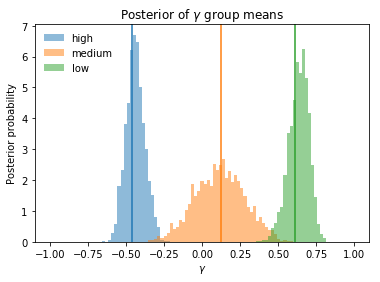

In [10]:
bins = np.linspace(-1, 1, 100)

fig, ax = plt.subplots()

for g, group in enumerate(groups):
    ax.hist(model.trace['gamma_{}_mu'.format(group)], bins=bins,
            histtype='stepfilled', alpha=0.5, color='C{}'.format(g),
            label=group, normed=True)
    
    ax.axvline(model.parameters[group]['gamma'].mean(), color='C{}'.format(g))
    
ax.legend(frameon=False)
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel('Posterior probability')
ax.set_title(r'Posterior of $\gamma$ group means');

With this, we can now ask: What is the probability that the `low` bias group has a higher mean $\gamma$ parameter than the `medium` bias group?

In [11]:
print('P(γ_low > γ_medium) = ',
      (model.trace['gamma_low_mu'] > model.trace['gamma_medium_mu']).mean())

P(γ_low > γ_medium) =  0.9985


# Prediction

We would also like to assess the model's ability to capture the data on an absolute level. To do this, we generate model predictions using the maximum-a-posteriori (MAP) estimates. For every trial, we simulate the model 5 times (this is specified via the `n_repeats` keyword below). Note that this prediction would also work for a structurally identical (i.e., same conditions and number of participants) held out data set that did not inform the parameter estimation. To do this, the data attached to the model would have to be exchanged using the `exchange_data` method.

In [12]:
model.predict(n_repeats=5)

5200it [02:49, 30.68it/s]


#### Data and model prediction (all data)

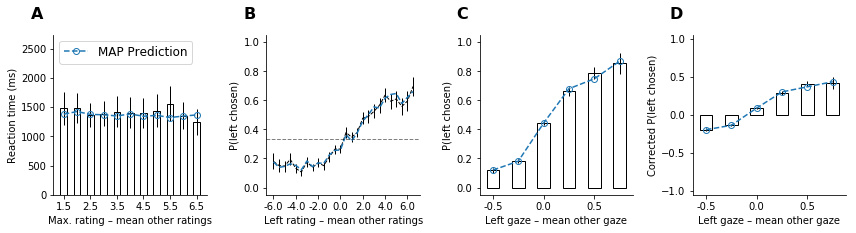

In [13]:
glam.plot_fit(model.data,
              [model.prediction],
              prediction_labels=['MAP Prediction']);

#### Data and model prediction (low bias condition only)

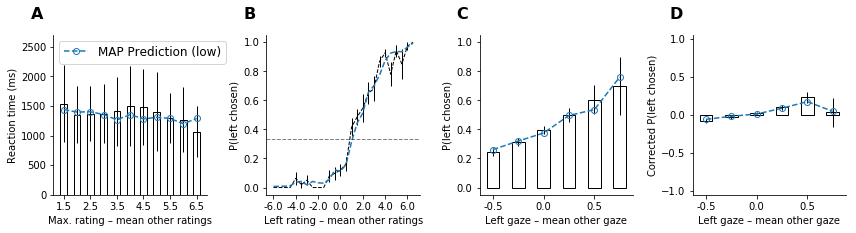

In [14]:
glam.plot_fit(model.data[model.data['group'] == 'low'],
              [model.prediction[model.prediction['group'] == 'low']],
              prediction_labels=['MAP Prediction (low)']);

#### Data and model prediction (medium bias condition only)

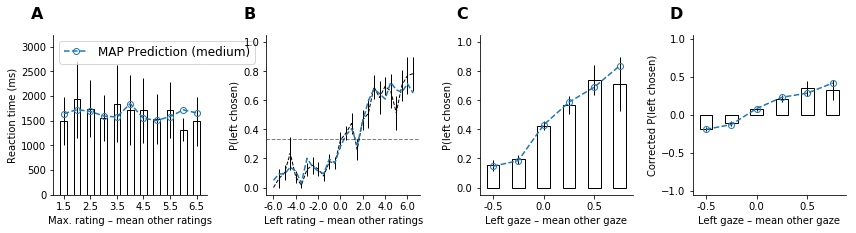

In [15]:
glam.plot_fit(model.data[model.data['group'] == 'medium'],
              [model.prediction[model.prediction['group'] == 'medium']],
              prediction_labels=['MAP Prediction (medium)']);

#### Data and model prediction (high bias condition only)

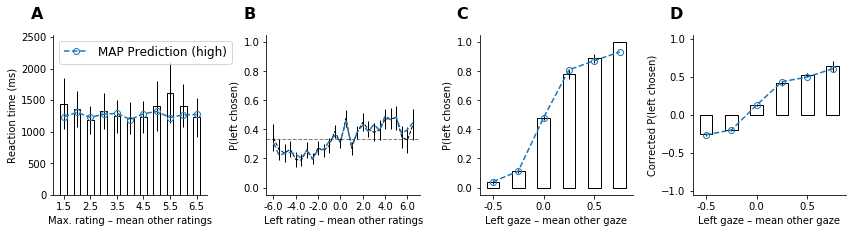

In [16]:
glam.plot_fit(model.data[model.data['group'] == 'high'],
              [model.prediction[model.prediction['group'] == 'high']],
              prediction_labels=['MAP Prediction (high)']);

# References

- Vaidya, A. R., & Fellows, L. K. (2015). Testing necessary regional frontal contributions to value assessment and fixation-based updating. Nature Communications, 6, 10120. https://doi.org/10.1038/ncomms10120

- Kucukelbir, A., Ranganath, R., Gelman, A., & Blei, D. M. (2015). Automatic Variational Inference in Stan. ArXiv:1506.03431 [Stat]. Retrieved from http://arxiv.org/abs/1506.03431